# ELI5 - Research Paper from PubMed
Explain Like I'm 5, a research paper from PubMed.

### Install Libraries

In [1]:
#!pip -q install langchain openai tiktoken
#!pip install rouge
#!pip install wordcloud

In [2]:
#!pip install pubmed_parser

In [3]:
from dotenv import load_dotenv
load_dotenv()

True

### Scrape Abstract Text From PubMed URL

Effect of Weekly Subcutaneous Semaglutide (Ozempic) vs Daily Liraglutide (Victoza and Saxenda) on Body Weight in Adults With Overweight or Obesity Without Diabetes: The STEP 8 Randomized Clinical Trial 

The script retrieves the HTML content of a PubMed research paper URL and uses BeautifulSoup to extract the abstract, making it available for further analysis.

In [10]:
url = 'https://pubmed.ncbi.nlm.nih.gov/35015037/'

In [11]:
import requests
from bs4 import BeautifulSoup

# Fetch the HTML content from the URL
response = requests.get(url)
html_content = response.text

# Parse the HTML content using BeautifulSoup
soup = BeautifulSoup(html_content, "html.parser")

# Find the div with class 'abstract' and id 'abstract'
abstract_div = soup.find('div', {"class": "abstract", "id": "abstract"})

# Extract and print the text from the div if it's found
if abstract_div:
    abstract_text = abstract_div.get_text(strip=True)
    print(abstract_text)
else:
    print("Abstract not found.")


AbstractImportance:Phase 3 trials have not compared semaglutide and liraglutide, glucagon-like peptide-1 analogues available for weight management.Objective:To compare the efficacy and adverse event profiles of once-weekly subcutaneous semaglutide, 2.4 mg, vs once-daily subcutaneous liraglutide, 3.0 mg (both with diet and physical activity), in people with overweight or obesity.Design, setting, and participants:Randomized, open-label, 68-week, phase 3b trial conducted at 19 US sites from September 2019 (enrollment: September 11-November 26) to May 2021 (end of follow-up: May 11) in adults with body mass index of 30 or greater or 27 or greater with 1 or more weight-related comorbidities, without diabetes (N = 338).Interventions:Participants were randomized (3:1:3:1) to receive once-weekly subcutaneous semaglutide, 2.4 mg (16-week escalation; n = 126), or matching placebo, or once-daily subcutaneous liraglutide, 3.0 mg (4-week escalation; n = 127), or matching placebo, plus diet and phys

`CharacterTextSplitter` is being used to divide the abstract text into manageable sections and converts these sections into `Document` objects, preparing them for summarization.

In [12]:
from langchain.docstore.document import Document
from langchain.text_splitter import CharacterTextSplitter

model_name = "gpt-3.5-turbo"
text_splitter = CharacterTextSplitter.from_tiktoken_encoder(
    model_name=model_name
)

texts = text_splitter.split_text(abstract_text)

docs = [Document(page_content=t) for t in texts]
print(len(docs))

1


#### Create API Key as Environment File

Preparing the environment for OpenAI API interaction by setting up the API key and initializing the language model instance.

In [13]:
env_content = "OPENAI_API_KEY='sk-abcd'"
#Replace this with your own API KI

#with open('.env', 'w') as file:
#    file.write(env_content)
#print("File '.env' has been created and the API key information has been written into it.")


In [14]:
import sys
import os
sys.path.append('../..')

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file
OPENAI_API_KEY = os.environ['OPENAI_API_KEY']

In [15]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(temperature=0, openai_api_key=OPENAI_API_KEY, model_name=model_name)

### Prompt Engineering

Creating prompts to instruct the AI on how to process the abstract text, aiming to simplify and explain the content and extract any structured or numerical data from the conclusions.

In [16]:
from langchain.prompts import PromptTemplate

prompt_template = """

Read the {text} carefully, then explain the extract, line by line, in an easy to understand language.

"""

prompt = PromptTemplate(template=prompt_template, input_variables=["text"])

In [17]:
prompt_template_2 = """

Read the {text} carefully, if there is data present in the text,
then extract it and arrange it in form of a dataframe. 

"""

prompt2 = PromptTemplate(template=prompt_template_2, input_variables=["text"])



### Fetch Number of Tokens

Implementing a function to count the tokens in the abstract, ensuring that the input does not exceed the model's token limit of 4097. Depending on the token count, the script selects an appropriate summarization approach, either processing the text directly or using a map-reduce strategy for longer texts.

In [18]:
import tiktoken

def num_tokens_from_string(string: str, encoding_name: str) -> int:
    encoding = tiktoken.encoding_for_model(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens

num_tokens = num_tokens_from_string(abstract_text, model_name)
print(num_tokens)

887


In [19]:
from langchain.chains.summarize import load_summarize_chain
import textwrap
from time import monotonic

gpt_35_turbo_max_tokens = 4097
verbose = True

if num_tokens < gpt_35_turbo_max_tokens:
  #chain = load_summarize_chain(llm, chain_type="stuff", prompt=prompt, verbose=verbose)
  chain = load_summarize_chain(llm, chain_type="stuff", prompt=prompt, verbose=verbose)

else:
  chain = load_summarize_chain(llm, chain_type="map_reduce", map_prompt=prompt,combine_prompt=prompt, verbose=verbose)

start_time = monotonic()
summary = chain.run(docs)

/Users/akshaysingh/anaconda3/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `run` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(




> Entering new StuffDocumentsChain chain...


> Entering new LLMChain chain...
Prompt after formatting:


Read the AbstractImportance:Phase 3 trials have not compared semaglutide and liraglutide, glucagon-like peptide-1 analogues available for weight management.Objective:To compare the efficacy and adverse event profiles of once-weekly subcutaneous semaglutide, 2.4 mg, vs once-daily subcutaneous liraglutide, 3.0 mg (both with diet and physical activity), in people with overweight or obesity.Design, setting, and participants:Randomized, open-label, 68-week, phase 3b trial conducted at 19 US sites from September 2019 (enrollment: September 11-November 26) to May 2021 (end of follow-up: May 11) in adults with body mass index of 30 or greater or 27 or greater with 1 or more weight-related comorbidities, without diabetes (N = 338).Interventions:Participants were randomized (3:1:3:1) to receive once-weekly subcutaneous semaglutide, 2.4 mg (16-week escalation; n = 126), or matching placebo,

In [20]:
if num_tokens < gpt_35_turbo_max_tokens:
  #chain = load_summarize_chain(llm, chain_type="stuff", prompt=prompt, verbose=verbose)
  chain = load_summarize_chain(llm, chain_type="stuff", prompt=prompt2, verbose=verbose)

else:
  chain = load_summarize_chain(llm, chain_type="map_reduce", map_prompt=prompt2,combine_prompt=prompt, verbose=verbose)

summary2 = chain.run(docs)



> Entering new StuffDocumentsChain chain...


> Entering new LLMChain chain...
Prompt after formatting:


Read the AbstractImportance:Phase 3 trials have not compared semaglutide and liraglutide, glucagon-like peptide-1 analogues available for weight management.Objective:To compare the efficacy and adverse event profiles of once-weekly subcutaneous semaglutide, 2.4 mg, vs once-daily subcutaneous liraglutide, 3.0 mg (both with diet and physical activity), in people with overweight or obesity.Design, setting, and participants:Randomized, open-label, 68-week, phase 3b trial conducted at 19 US sites from September 2019 (enrollment: September 11-November 26) to May 2021 (end of follow-up: May 11) in adults with body mass index of 30 or greater or 27 or greater with 1 or more weight-related comorbidities, without diabetes (N = 338).Interventions:Participants were randomized (3:1:3:1) to receive once-weekly subcutaneous semaglutide, 2.4 mg (16-week escalation; n = 126), or matching placebo,

In [21]:
#print(summary)

In [43]:
#print(summary2)

### Data Cleaning

Transforms any extracted data or conclusions into a pandas DataFrame, cleaning the data by removing unnecessary whitespace and handling missing values.

In [23]:
import pandas as pd
from io import StringIO

# Check if summary2 contains data
if summary2.strip():  # Checks if summary2 is not just whitespace
    # Using StringIO to simulate a file-like object
    data = StringIO(summary2)

    # Creating the DataFrame
    df = pd.read_csv(data, sep="|", skipinitialspace=True)

    # Trimming whitespace from all string elements in the DataFrame
    df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

    if df.iloc[:, 0].isnull().all():
        df = df.drop(df.columns[0], axis=1)
    
else:
    df = "contains no data"


/Users/akshaysingh/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [24]:
if df.empty:
        print("Empty DataFrame")

In [25]:
if df.empty:
        print("")
elif df.iloc[:, -1].isnull().all():
    df = df.drop(df.columns[-1], axis=1)

In [26]:
def check_dash_or_float(cell):
    if isinstance(cell, float):
        return False  # floats are not considered as '---'
    return all(c == '-' for c in str(cell))  # Check if all characters are dashes in non-floats

# Check if all values in the first row contain only dashes
if df.empty:
        print("")
elif all(check_dash_or_float(cell) for cell in df.iloc[0]):
    df = df.drop(df.index[0])

In [27]:
df.head()

,Treatment,Mean Weight Change (%),Odds of Achieving 10% or more Weight Loss,Odds of Achieving 15% or more Weight Loss,Odds of Achieving 20% or more Weight Loss,Proportion Discontinuing Treatment (%),Gastrointestinal Adverse Events Reported (%)
1,Semaglutide,-15.8,70.9,55.6,38.5,13.5,84.1
2,Liraglutide,-6.4,25.6,12.0,6.0,27.6,82.7
3,Pooled Placebo,-1.9,N/A,N/A,N/A,N/A,N/A


In [28]:
df_filled = df.replace("N/A", 0).fillna(0)

In [29]:
df_filled = df.replace("-", 0).fillna(0)

In [30]:
df_filled.head()

,Treatment,Mean Weight Change (%),Odds of Achieving 10% or more Weight Loss,Odds of Achieving 15% or more Weight Loss,Odds of Achieving 20% or more Weight Loss,Proportion Discontinuing Treatment (%),Gastrointestinal Adverse Events Reported (%)
1,Semaglutide,-15.8,70.9,55.6,38.5,13.5,84.1
2,Liraglutide,-6.4,25.6,12.0,6.0,27.6,82.7
3,Pooled Placebo,-1.9,N/A,N/A,N/A,N/A,N/A


### Auto Data Visualization

Generates a prompt to create visualization code, aiming to graphically represent any data found in the research paper's conclusion.

In [31]:
docs = [Document(page_content=row.to_json()) for index, row in df_filled.iterrows()]
print(len(docs))

3


In [32]:
prompt_template_3 = """

Read the {text} carefully, create a visualization to summarize this dataframe. 
Make the visualization intuitive to understand.
Provide with only the code to create the visualization and nothing else. 

"""

prompt3 = PromptTemplate(template=prompt_template_3, input_variables=["text"])
chain = load_summarize_chain(llm, chain_type="stuff", prompt=prompt3, verbose=verbose)
summary3 = chain.run(docs)



> Entering new StuffDocumentsChain chain...


> Entering new LLMChain chain...
Prompt after formatting:


Read the {"Treatment       ":"Semaglutide","Mean Weight Change (%) ":"-15.8","Odds of Achieving 10% or more Weight Loss ":"70.9","Odds of Achieving 15% or more Weight Loss ":"55.6","Odds of Achieving 20% or more Weight Loss ":"38.5","Proportion Discontinuing Treatment (%) ":"13.5","Gastrointestinal Adverse Events Reported (%) ":"84.1"}

{"Treatment       ":"Liraglutide","Mean Weight Change (%) ":"-6.4","Odds of Achieving 10% or more Weight Loss ":"25.6","Odds of Achieving 15% or more Weight Loss ":"12.0","Odds of Achieving 20% or more Weight Loss ":"6.0","Proportion Discontinuing Treatment (%) ":"27.6","Gastrointestinal Adverse Events Reported (%) ":"82.7"}

{"Treatment       ":"Pooled Placebo","Mean Weight Change (%) ":"-1.9","Odds of Achieving 10% or more Weight Loss ":"N\/A","Odds of Achieving 15% or more Weight Loss ":"N\/A","Odds of Achieving 20% or more Weight Loss ":"N\/A"

## Summary

In [33]:
print(summary)

In this study, researchers compared the effectiveness and side effects of two different medications, semaglutide and liraglutide, which are both used for weight management. The study involved 338 adults who were overweight or obese but did not have diabetes. Participants were randomly assigned to receive either once-weekly semaglutide injections or once-daily liraglutide injections, along with diet and exercise counseling.

The primary goal of the study was to measure the percentage change in body weight after 68 weeks of treatment. The researchers also looked at the percentage of participants who achieved significant weight loss (10%, 15%, or 20%) with each medication. The study was conducted at 19 sites in the US from September 2019 to May 2021.

The results showed that participants who received semaglutide had a significantly greater weight loss compared to those who received liraglutide. The odds of achieving 10%, 15%, or 20% weight loss were much higher with semaglutide. Additiona

### Data From Abstract

In [37]:
df.head()

,Treatment,Mean Weight Change (%),Odds of Achieving 10% or more Weight Loss,Odds of Achieving 15% or more Weight Loss,Odds of Achieving 20% or more Weight Loss,Proportion Discontinuing Treatment (%),Gastrointestinal Adverse Events Reported (%)
1,Semaglutide,-15.8,70.9,55.6,38.5,13.5,84.1
2,Liraglutide,-6.4,25.6,12.0,6.0,27.6,82.7
3,Pooled Placebo,-1.9,N/A,N/A,N/A,N/A,N/A


In [38]:
#print(summary2)

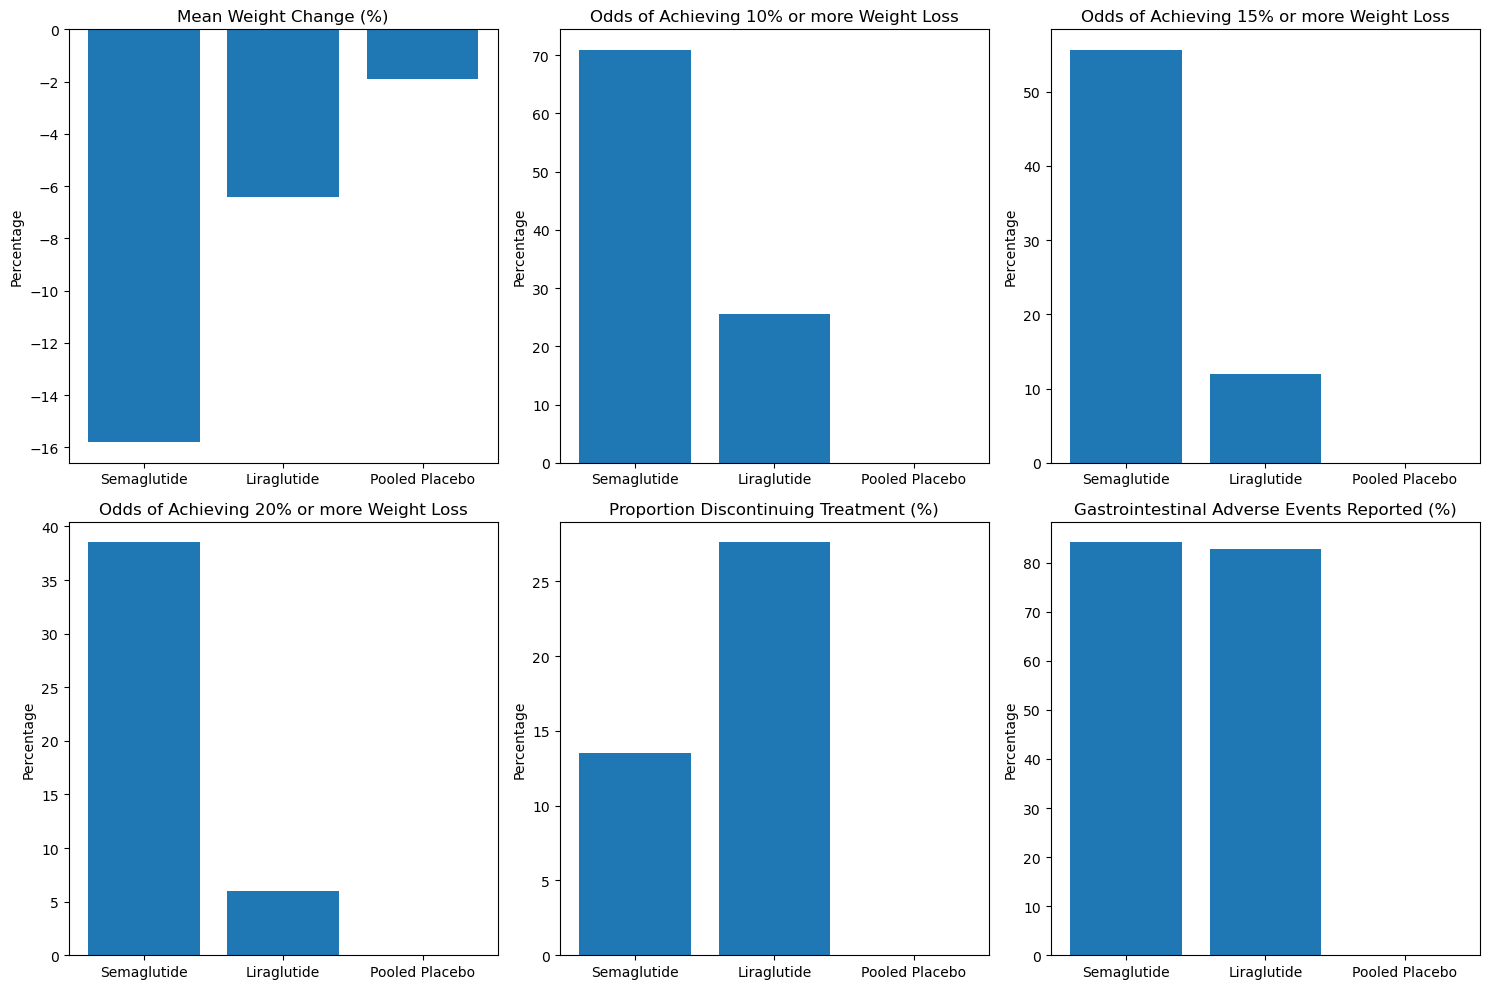

In [35]:
if df.empty:
        print("")
else:
    exec(summary3)

In [42]:
!jupyter nbconvert --to script ELI5 - PubMed.ipynb


[NbConvertApp] WARNING | pattern 'ELI5' matched no files
[NbConvertApp] WARNING | pattern '-' matched no files
[NbConvertApp] Converting notebook PubMed.ipynb to script
[NbConvertApp] Writing 5596 bytes to PubMed.py
